# **Data**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils import pad_sequences,plot_model
from sklearn import model_selection
from sklearn.metrics import classification_report,confusion_matrix
from string import printable
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,load_model
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, ELU, LSTM, Embedding, BatchNormalization, Conv1D, MaxPooling1D,GRU,SimpleRNN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from scipy.io.arff import loadarff 
from tensorflow import keras
%matplotlib inline

In [2]:
import tensorboard
from datetime import datetime
from packaging import version

In [3]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [4]:
df=pd.read_csv('phishing_site_urls.csv')

In [5]:
df.shape

(549346, 2)

In [6]:
df['URL'][0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [7]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

In [8]:
df['Label'].value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

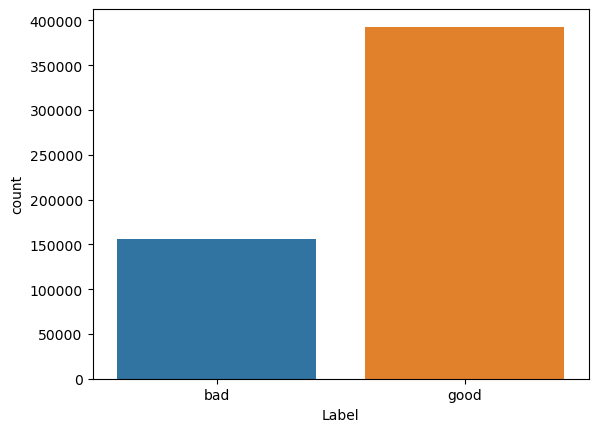

In [9]:
sns.countplot(x='Label', data=df)

In [10]:
df.loc[df["Label"] == 'bad', "Label"] = 0
df.loc[df["Label"] == "good", "Label"] = 1
df.Label.value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

In [11]:
class_1_indices = np.where(df.Label == 1)[0][:156422]
class_0_indices = np.where(df.Label == 0)[0]

In [12]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0


# example preprocessing

In [13]:
character_encoding=[printable.index(x) + 1 for x in printable]
for x in range(0,len(character_encoding)):
  print(printable[x],"=",character_encoding[x],"\n")

0 = 1 

1 = 2 

2 = 3 

3 = 4 

4 = 5 

5 = 6 

6 = 7 

7 = 8 

8 = 9 

9 = 10 

a = 11 

b = 12 

c = 13 

d = 14 

e = 15 

f = 16 

g = 17 

h = 18 

i = 19 

j = 20 

k = 21 

l = 22 

m = 23 

n = 24 

o = 25 

p = 26 

q = 27 

r = 28 

s = 29 

t = 30 

u = 31 

v = 32 

w = 33 

x = 34 

y = 35 

z = 36 

A = 37 

B = 38 

C = 39 

D = 40 

E = 41 

F = 42 

G = 43 

H = 44 

I = 45 

J = 46 

K = 47 

L = 48 

M = 49 

N = 50 

O = 51 

P = 52 

Q = 53 

R = 54 

S = 55 

T = 56 

U = 57 

V = 58 

W = 59 

X = 60 

Y = 61 

Z = 62 

! = 63 

" = 64 

# = 65 

$ = 66 

% = 67 

& = 68 

' = 69 

( = 70 

) = 71 

* = 72 

+ = 73 

, = 74 

- = 75 

. = 76 

/ = 77 

: = 78 

; = 79 

< = 80 

= = 81 

> = 82 

? = 83 

@ = 84 

[ = 85 

\ = 86 

] = 87 

^ = 88 

_ = 89 

` = 90 

{ = 91 

| = 92 

} = 93 

~ = 94 

  = 95 

	 = 96 


 = 97 

 = 98 

 = 99 

 = 100 



In [14]:
url='https://www.apple.com/'
encoded=[printable.index(x) + 1 for x in url if x in printable]
print(encoded)

[18, 30, 30, 26, 29, 78, 77, 77, 33, 33, 33, 76, 11, 26, 26, 22, 15, 76, 13, 25, 23, 77]


# **Pre-processing**

In [15]:
#1) encoding the characters in URL from 1 to 100, using nested list comprehension.
url_encoded = [[printable.index(x) + 1 for x in url if x in printable] for url in df.URL]

In [16]:
#2)Length normalization, The length of all URL's normalized at fixed length, if the (url length< fixed length) zeroes are added at front of the url,
# if the (url length> fixed length) the etra character are intercepted from the end
max_len=75
X = pad_sequences(url_encoded, maxlen=max_len, truncating='post')

In [17]:
y = np.array(df.Label)

In [18]:
X.shape

(549346, 75)

In [19]:
X

array([[24, 25, 12, ..., 77, 32, 15],
       [33, 33, 33, ..., 11, 14, 19],
       [29, 15, 28, ...,  4,  3,  2],
       ...,
       [ 0,  0,  0, ..., 28, 17, 77],
       [ 0,  0,  0, ..., 28, 17, 77],
       [ 0,  0,  0, ..., 24, 16, 25]])

In [20]:
y.shape

(549346,)

# **Splitting-data**

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=33)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [22]:
model = models.Sequential([
    layers.Input(shape=X_train.shape[1]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid'),
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4864      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 3

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
X_train = np.asarray(X_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [27]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [28]:
epochs = 50
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[early_stopping])

Epoch 1/50
13734/13734 [==============================] - 71s 5ms/step - loss: 0.5016 - accuracy: 0.7544 - val_loss: 0.4419 - val_accuracy: 0.8124
Epoch 2/50
13734/13734 [==============================] - 66s 5ms/step - loss: 0.4622 - accuracy: 0.7963 - val_loss: 0.4162 - val_accuracy: 0.8260
Epoch 3/50
13734/13734 [==============================] - 67s 5ms/step - loss: 0.4471 - accuracy: 0.8062 - val_loss: 0.4100 - val_accuracy: 0.8324
Epoch 4/50
13734/13734 [==============================] - 69s 5ms/step - loss: 0.4382 - accuracy: 0.8126 - val_loss: 0.4027 - val_accuracy: 0.8335
Epoch 5/50
13734/13734 [==============================] - 69s 5ms/step - loss: 0.4314 - accuracy: 0.8171 - val_loss: 0.3967 - val_accuracy: 0.8401
Epoch 6/50
13734/13734 [==============================] - 68s 5ms/step - loss: 0.4271 - accuracy: 0.8193 - val_loss: 0.3896 - val_accuracy: 0.8442
Epoch 7/50
13734/13734 [==============================] - 68s 5ms/step - loss: 0.4227 - accuracy: 0.8210 - val_loss: 0

In [29]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
epochs = 20
batch_size = 32

his1=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[early_stopping])

Epoch 1/20
13734/13734 [==============================] - 58s 4ms/step - loss: 0.3933 - accuracy: 0.8376 - val_loss: 0.3661 - val_accuracy: 0.8570
Epoch 2/20
13734/13734 [==============================] - 58s 4ms/step - loss: 0.3897 - accuracy: 0.8400 - val_loss: 0.3665 - val_accuracy: 0.8577
Epoch 3/20
13734/13734 [==============================] - 56s 4ms/step - loss: 0.3885 - accuracy: 0.8403 - val_loss: 0.3659 - val_accuracy: 0.8572
Epoch 4/20
13734/13734 [==============================] - 2598s 189ms/step - loss: 0.3879 - accuracy: 0.8417 - val_loss: 0.3649 - val_accuracy: 0.8582
Epoch 5/20
13734/13734 [==============================] - 44s 3ms/step - loss: 0.3863 - accuracy: 0.8417 - val_loss: 0.3659 - val_accuracy: 0.8586
Epoch 6/20
13734/13734 [==============================] - 54s 4ms/step - loss: 0.3865 - accuracy: 0.8417 - val_loss: 0.3658 - val_accuracy: 0.8582
Epoch 7/20
13734/13734 [==============================] - 72s 5ms/step - loss: 0.3864 - accuracy: 0.8422 - val_los

In [31]:
model.save('Mini_Proj_saved.keras')

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print('\nValidation Accuracy', test_accuracy, '\n')

1717/1717 [==============================] - 6s 3ms/step - loss: 0.3604 - accuracy: 0.8601

Validation Accuracy 0.860107421875 



In [33]:
predictions=model.predict(X_test)

1717/1717 [==============================] - 5s 3ms/step


In [34]:
predictions = (predictions>=0.5).astype(int)

In [35]:
predictions.shape

(54935, 1)

In [36]:
cm=confusion_matrix(y_test,predictions)
cm

array([[11390,  4269],
       [ 3416, 35860]], dtype=int64)

In [37]:
predictions.shape

(54935, 1)

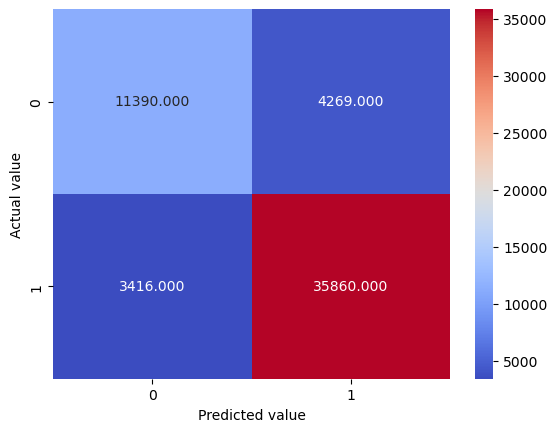

In [38]:
sns.heatmap(cm, annot=True, cmap='coolwarm',fmt='0.3f')
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

In [39]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.8601073996541367

In [40]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75     15659
         1.0       0.89      0.91      0.90     39276

    accuracy                           0.86     54935
   macro avg       0.83      0.82      0.83     54935
weighted avg       0.86      0.86      0.86     54935



In [41]:
h1=his1.history
h1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

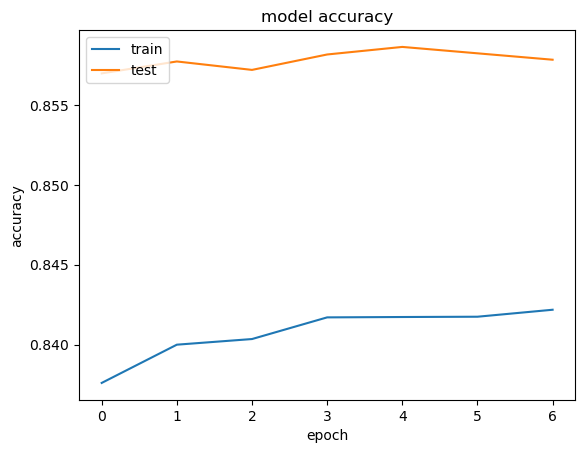

In [42]:
# summarize history for accuracy
plt.plot(h1['accuracy'])
plt.plot(h1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

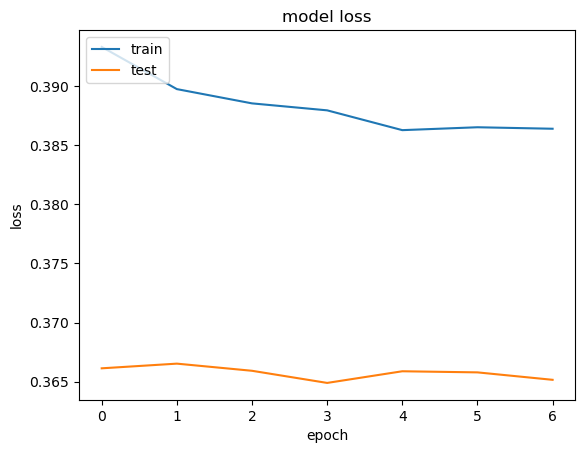

In [43]:
# summarize history for loss
plt.plot(h1['loss'])
plt.plot(h1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ***TESTING***

In [45]:
# Took a random website link from Phishtank which has all phishing links
output_gru('enterspages.com/QC/St-Leonard-apartment.html')

1/1 [==============================] - 0s 40ms/step


(0, array([[0.32751212]], dtype=float32))

In [46]:
cnn_gru_model=load_model("Mini_Proj_saved.keras")

In [47]:
cnn_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4864      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 3

In [48]:
cnn_gru_model.evaluate(X_train,y_train,verbose=1)

13734/13734 [==============================] - 47s 3ms/step - loss: 0.3374 - accuracy: 0.8705


[0.3374110460281372, 0.8704730272293091]

In [49]:
test_url='www.youtube.com'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 182ms/step


array([[0.32751212]], dtype=float32)

In [50]:
test_url='enterspages.com/QC/St-Leonard-apartment.html'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

1/1 [==============================] - 0s 39ms/step


array([[0.32751212]], dtype=float32)